# Inference test for prompt engineering

## Load Drive

In [ ]:
import sys

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# add following directory to package dir
if "/content/drive/MyDrive/CLASS_AGNOSTIC_COUNTER/" not in sys.path:
  sys.path.append("/content/drive/MyDrive/CLASS_AGNOSTIC_COUNTER/")

## Install dependencies

In [ ]:
!pip install torch torchaudio torchvision torchtext torchdata > 0
!pip install git+https://github.com/openai/CLIP.git > 0
!pip install einops > 0
!pip install --upgrade torch torchvision > 0
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning > 0
!pip install gradio > 0

## Inference test

In [1]:
import torch, os, cv2
import run
import numpy as np
import pandas as pd
import util.misc as misc
import torchvision.transforms.functional as TF
from PIL import Image
import torch.nn.functional as F

SCALE_FACTOR = 60

/home/matteopierucci/anaconda3/envs/clipcount/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class InferenceModel:

  def __init__(self, ckpt):
    self.model = run.Model.load_from_checkpoint(ckpt, strict=False)
    self.model.eval()

  def infer(self, img, prompt):
    model = self.model
    model.eval()
    model.model = model.model.cuda()
    with torch.no_grad():
        # reshape height to 384, keep aspect ratio
        #img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).cuda()
        #img = TF.resize(img, (384))
        img = torch.from_numpy(img).unsqueeze(0).cuda()
        #print(img.shape)

        img = img.float()/255.
        img = torch.clamp(img, 0, 1)
        prompt = [prompt]
        with torch.cuda.amp.autocast():
            raw_h, raw_w = img.shape[2:]
            patches, _ = misc.sliding_window(img,stride=128)
            #covert to batch
            patches = torch.from_numpy(patches).float().to(img.device)
            prompt = np.repeat(prompt, patches.shape[0], axis=0)
            output = model.forward(patches, prompt)
            output.unsqueeze_(1)
            output = misc.window_composite(output, stride=128)
            output = output.squeeze(1)
            #crop to original width
            output = output[:, :, :raw_w]
        pred_cnt = torch.sum(output[0]/SCALE_FACTOR).item()
        pred_density = output[0].detach().cpu().numpy()
        # normalize
        pred_density = pred_density/pred_density.max()
        pred_density_write = 1. - pred_density
        pred_density_write = cv2.applyColorMap(np.uint8(255*pred_density_write), cv2.COLORMAP_JET)
        pred_density_write = pred_density_write/255.
        # pred_rgb = cv2.applyColorMap(np.uint8(255*pred_density), cv2.COLORMAP_JET)
        img = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()


        heatmap_pred = 0.40 * img + 0.60 * pred_density_write
        heatmap_pred = heatmap_pred/heatmap_pred.max()
    return heatmap_pred, pred_cnt

In [3]:
model_ckpt = './ckpt/clipcount_pretrained.ckpt' # pre-trained model
#model_ckpt = './lightning_logs/exp_train_with_caption2_batch32/version_0/checkpoints/epoch=184-val_mae=17.49.ckpt'
inf_model = InferenceModel(model_ckpt)

In [111]:
img_directory = './data/FSC/images_384_VarV2'
img_filename =  '2004.jpg' # sunglasses image

img = Image.open(os.path.join(img_directory, img_filename))
img_array = np.array(img)
#prompt = "sunglasses made of two lenses"
#prompt = "sunglasses on a wall"
#prompt = "sunglasses"
prompt = "a group of sunglasses with different colors"

In [112]:
img_array = np.transpose(img_array, (2,0,1))

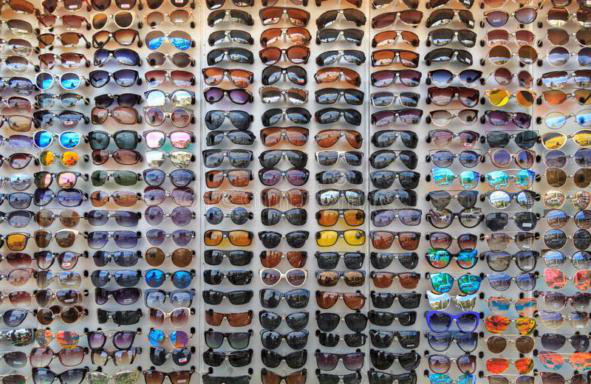

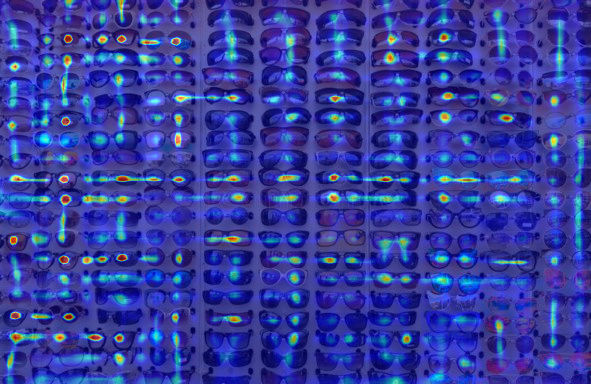

Prediction count: 328.25


In [113]:
heatmap, cnt = inf_model.infer(img_array, prompt)
res = Image.fromarray(np.uint8(255*heatmap))

img.show()
res.show()
print(f'Prediction count: {cnt}')

### Inference test on ambiguous image

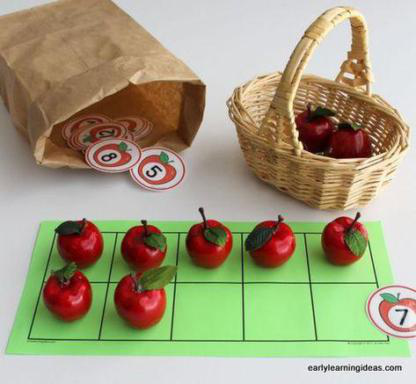

Prediction count: 10.2578125


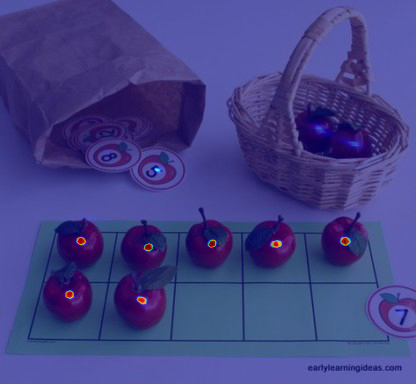

In [10]:
img_directory = './data/FSC/images_384_VarV2'
img_filename =  '2143.jpg' # apples image

img = Image.open(os.path.join(img_directory, img_filename))
img_array = np.array(img)
prompt = "round red real apples with apple stickers on the top left"
#prompt = "round red real apple"
#prompt = "apple drawings on a sticker"

img_array = np.transpose(img_array, (2,0,1))

heatmap, cnt = inf_model.infer(img_array, prompt)
res = Image.fromarray(np.uint8(255*heatmap))


img.show()
print(f'Prediction count: {cnt}')
res.show()

### Inference test of ambiguous image

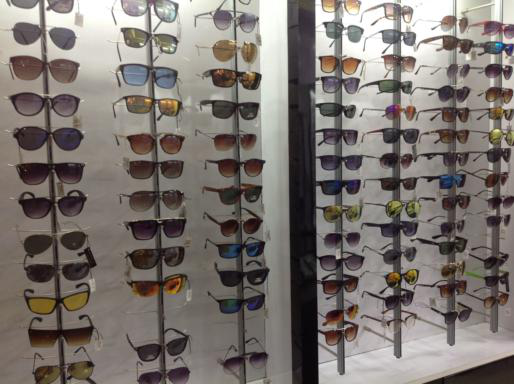

Prediction count: 106.0625


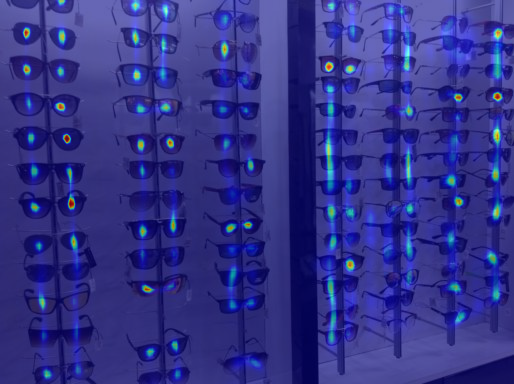

In [135]:
img_directory = './data/FSC/images_384_VarV2'
img_filename =  '6993.jpg' # apples image

img = Image.open(os.path.join(img_directory, img_filename))
img_array = np.array(img)

prompt = "a display of sunglasses"

img_array = np.transpose(img_array, (2,0,1))

heatmap, cnt = inf_model.infer(img_array, prompt)
res = Image.fromarray(np.uint8(255*heatmap))


img.show()
print(f'Prediction count: {cnt}')
res.show()

### Evaluate impact of different captions in sunglasses image

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline

DISPLAY_HEATMAPS = False

In [54]:
gt_cnt = 222

img_filename =  '2004.jpg' # sunglasses image

img = Image.open(os.path.join(img_directory, img_filename))
img_array = np.array(img)
img_array = np.transpose(img_array, (2,0,1))

prompt = "sunglasses"
generated_caption = "sunglasses on a wall in a shop in the market in san francisco"

captions = [
            "sunglasses",
            f"sunglasses in a scene of {generated_caption}",
            f"sunglasses in {generated_caption}",
            f"sunglasses in a photo of {generated_caption}",
            f"sunglasses in a photo that has been captioned as {generated_caption}",
            "eyeglasses",
            "sunglasses near other sunglasses",
            "sunglasses composed by two lenses",
            "couple of lenses",
            "two lenses attached",
            "sunglasses in a photo with a white wall",
            f"{generated_caption}",
            ""
            ]

dfs = []

for prompt in captions:
    pred_heatmap, pred_cnt = inf_model.infer(img_array, prompt)
    error_cnt = abs(gt_cnt - pred_cnt)
    
    df = pd.DataFrame({
        'Prompt': [prompt],
        'Predicted Count': [pred_cnt],
        'Error Count': [error_cnt]
    })
    
    dfs.append(df)

    if DISPLAY_HEATMAPS:
        plt.imshow(pred_heatmap, cmap='hot', interpolation='nearest')
        plt.title("prompt: "+ prompt + " - pred_cnt: " + str(pred_cnt) + "- err_cnt: " + str(error_cnt))
        plt.show()

# concatenate DataFrames in the list along axis 0
results_df = pd.concat(dfs, ignore_index=True)
results_df = results_df.sort_values(['Error Count'], ascending=[True])

results_df

,Prompt,Predicted Count,Error Count
6,sunglasses near other sunglasses,283.50,61.50
12,,284.50,62.50
8,couple of lenses,293.00,71.00
5,eyeglasses,309.75,87.75
9,two lenses attached,313.50,91.50
7,sunglasses composed by two lenses,316.50,94.50
11,sunglasses on a wall in a shop in the market i...,327.50,105.50
2,sunglasses in sunglasses on a wall in a shop i...,331.25,109.25
3,sunglasses in a photo of sunglasses on a wall ...,333.75,111.75
10,sunglasses in a photo with a white wall,334.00,112.00


### Evaluate impact of different captions in polka dots image

In [55]:
gt_cnt = 100
img_filename =  '5044.jpg' # polka dots

img = Image.open(os.path.join(img_directory, img_filename))
img_array = np.array(img)
img_array = np.transpose(img_array, (2,0,1))

prompt = "polka dots"
generated_caption = "this shirt is a must have for any occasion."

captions = [
            "polka dots",
            f"polka dots in a scene of {generated_caption}",
            f"polka dots in {generated_caption}",
            f"polka dots in a photo of {generated_caption}",
            f"polka dots in a photo that has been captioned as {generated_caption}",
            "polka dots near other polka dots",
            "polka dots in a photo with white background",
            "polka dots in a photo with a black shirt",
            "white and round polka dots on a black shirt",
            "polka dots in a photo with a man wearing a shirt",
            "dots on a shirt",
            "white dots on a shirt",
            f"{generated_caption}",
            ""
            ]

dfs = []

for prompt in captions:
    pred_heatmap, pred_cnt = inf_model.infer(img_array, prompt)
    error_cnt = abs(gt_cnt - pred_cnt)
    
    df = pd.DataFrame({
        'Prompt': [prompt],
        'Predicted Count': [pred_cnt],
        'Error Count': [error_cnt]
    })
    
    dfs.append(df)

    if DISPLAY_HEATMAPS:
        plt.imshow(pred_heatmap, cmap='hot', interpolation='nearest')
        plt.title("prompt: "+ prompt + " - pred_cnt: " + str(pred_cnt) + "- err_cnt: " + str(error_cnt))
        plt.show()

# concatenate DataFrames in the list along axis 0
results_df = pd.concat(dfs, ignore_index=True)
results_df = results_df.sort_values(['Error Count'], ascending=[True])

results_df

,Prompt,Predicted Count,Error Count
12,this shirt is a must have for any occasion.,97.0625,2.9375
3,polka dots in a photo of this shirt is a must ...,103.1250,3.1250
1,polka dots in a scene of this shirt is a must ...,103.5000,3.5000
2,polka dots in this shirt is a must have for an...,103.5000,3.5000
13,,96.3750,3.6250
11,white dots on a shirt,104.2500,4.2500
10,dots on a shirt,104.3125,4.3125
4,polka dots in a photo that has been captioned ...,104.3750,4.3750
7,polka dots in a photo with a black shirt,106.0000,6.0000
8,white and round polka dots on a black shirt,106.3750,6.3750


### Evaluate impact of different captions in flamingos image

In [57]:
gt_cnt = 13
img_filename =  '561.jpg' # polka dots

img = Image.open(os.path.join(img_directory, img_filename))
img_array = np.array(img)
img_array = np.transpose(img_array, (2,0,1))

prompt = "polka dots"
generated_caption = "flamingos in the water"

captions = [
            "flamingos",
            f"flamingos in a scene of {generated_caption}",
            f"flamingos in {generated_caption}",
            f"flamingos in a photo of {generated_caption}",
            f"flamingos in a photo that has been captioned as {generated_caption}",
            "flamingos in a lake and vegetation",
            "flamingos in an image with a background of vegetation",
            "flamingos near a lake",
            "pink birds",
            "pink birds near a lake",
            "pink flamingos near a lake",
            f"{generated_caption}",
            ""
            ]

dfs = []

for prompt in captions:
    pred_heatmap, pred_cnt = inf_model.infer(img_array, prompt)
    error_cnt = abs(gt_cnt - pred_cnt)
    
    df = pd.DataFrame({
        'Prompt': [prompt],
        'Predicted Count': [pred_cnt],
        'Error Count': [error_cnt]
    })
    
    dfs.append(df)

    if DISPLAY_HEATMAPS:
        plt.imshow(pred_heatmap, cmap='hot', interpolation='nearest')
        plt.title("prompt: "+ prompt + " - pred_cnt: " + str(pred_cnt) + "- err_cnt: " + str(error_cnt))
        plt.show()

# concatenate DataFrames in the list along axis 0
results_df = pd.concat(dfs, ignore_index=True)
results_df = results_df.sort_values(['Error Count'], ascending=[True])

results_df

,Prompt,Predicted Count,Error Count
12,,17.296875,4.296875
9,pink birds near a lake,17.640625,4.640625
8,pink birds,18.156250,5.156250
4,flamingos in a photo that has been captioned a...,18.671875,5.671875
11,flamingos in the water,18.703125,5.703125
6,flamingos in an image with a background of veg...,18.750000,5.750000
7,flamingos near a lake,18.781250,5.781250
2,flamingos in flamingos in the water,19.140625,6.140625
10,pink flamingos near a lake,19.187500,6.187500
3,flamingos in a photo of flamingos in the water,19.234375,6.234375


## Find best caption at inference time

### Load JSON files

In [4]:
import json

density_path = "./data/FSC/gt_density_map_adaptive_384_VarV2"

train_test_split_json_file = "./data/FSC/FSC_147/Train_Test_Val_FSC_147.json"
captions_json_file = "./captioning-module/generated_captions_FSC_147.json"
promptcap_json_file = "./captioning-module/promptcap_generated_captions_FSC_147.json"
anno_file = "./data/FSC/FSC_147/annotation_FSC_147_384.json"

with open(train_test_split_json_file, 'r') as file:
    train_test_split_json = json.load(file)

with open(captions_json_file, 'r') as file:
    captions_json = json.load(file)
    
with open(promptcap_json_file, 'r') as file:
    promptcap_json = json.load(file)
    
with open(anno_file) as f:
    annotations = json.load(f)
    
image_class_dict = {}
image_class_txt = "./data/FSC/FSC_147/ImageClasses_FSC_147.txt"

with open(image_class_txt, 'r') as file:
    lines = file.readlines()
    
    for line in lines:
        image_name, label = line.strip().split('\t')
        image_class_dict[image_name] = label

### Inference on Test images

In [5]:
from util.FSC147 import FSC147
import math
from tqdm import tqdm
from models import clip_count

In [6]:
dataset_test = FSC147(split = "test", prompt_with_captioning=True)

ids = []

for image_tensor, density, _, _, prompt_cap, gen_caption, class_name, im_id in dataset_test:
    gt_cnt = torch.sum(density/SCALE_FACTOR).item()

    img = np.transpose(image_tensor.numpy(), (1, 2, 0))
    
    #plt.imshow(img)
    #plt.title(str(gt_cnt) + " - " + str(class_name))
    #plt.axis('off')
    #plt.show()
    
    if im_id in ids:
        print("same: ", im_id)
        continue
    ids.append(im_id)
    
    break

In [10]:
dataset_test = FSC147(split = "test", prompt_with_captioning=True)
#dataset_test = torch.utils.data.Subset(dataset_test, [x for x in range(1, 51)])

df = pd.DataFrame(columns=['Prompt', 'MAE', 'RMSE'])

ids = []

prompts = [
    "",
    "in a scene of {generated_caption}",
    "in {generated_caption}",
    "in a photo of {generated_caption}",
    "in a photo that has been captioned as follows {generated_caption}",
    "near other {class_name}",
    "{prompt_cap}"
]

for prompt in prompts:
    cumulative_mae = 0
    cumulative_rmse = 0 
    for image_tensor, density, _, _, prompt_cap, gen_caption, class_name, im_id in tqdm(dataset_test, desc="Processing dataset"):
        
        '''if id in ids:
            print("same: ", im_id)
            continue
        ids.append(id)'''
        
        # count on density map to obtain ground truth
        gt_cnt = torch.sum(density/SCALE_FACTOR).item()
        #print(gt_cnt)
        
        if "{generated_caption}" in prompt:
            text = f"{class_name} {prompt}".format(generated_caption=gen_caption)
        elif "{class_name}" in prompt:
            text = f"{class_name} {prompt}".format(class_name=class_name)
        elif "{prompt_cap}" in prompt:
            text = prompt_cap
        else:
            text = class_name
        
        img_array = np.array(image_tensor)
        #print(img_array.shape)
        _, pred_cnt = inf_model.infer(img_array, text)
        #print(pred_cnt)
        
        # evaluate absolute error
        cnt_err = abs(pred_cnt - gt_cnt)
        
        #print(f'cnt_err - [{cnt_err}], text - [{text}]')
        
        cumulative_mae += cnt_err
        cumulative_rmse += cnt_err ** 2
    
    cumulative_mae /= len(dataset_test)
    cumulative_rmse /= len(dataset_test)
    cumulative_rmse = math.sqrt(cumulative_rmse)

    new_df = pd.DataFrame({'Prompt': [prompt], 'MAE': [cumulative_mae], 'RMSE': [cumulative_rmse]})
    df = pd.concat([df, new_df], ignore_index=True)

Processing dataset:   0%|          | 0/1190 [00:00<?, ?it/s]

finger foods in a photo of a selection of food from the menu


In [8]:
df.sort_values(by=['MAE', 'RMSE'])

,Prompt,MAE,RMSE
3,in a photo of {generated_caption},47.913295,152.210411
1,in a scene of {generated_caption},48.114923,152.392194
2,in {generated_caption},48.442090,152.651035
5,{prompt_cap},48.511148,152.846824
4,in a photo that has been captioned as follows ...,48.518035,152.787456
0,,49.008936,153.242978
